### The objective is to test some images and see the metric results

## Imports

In [1]:
## Imports

from src.PatchImageTool import PatchImageTool
from src.PytorchUtil import PytorchUtil as torchUtil
from src.UpscaleNN import UpscaleNN

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.nntools as nt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS
import cv2
import math

import platform
import socket
import os

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()

force_cpu = True

if not device:
    if torch.cuda.is_available() and not force_cpu:
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)


import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

2023-12-08 18:16:26.421344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 18:16:26.421372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 18:16:26.421392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 18:16:26.427050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cpu


## Define the model

In [2]:
small_dataset = None
small_valid_dataset = None
stats_manager = None

super_res_factor = 2

lr = 1e-3
batch_size = 512

torch.cuda.empty_cache()
r = UpscaleNN(super_res_factor = super_res_factor) 
r = r.to(device)

path = "results/superresol-upscale2"

adam = torch.optim.Adam(r.parameters(), lr=lr)

def criterion(y, d):
    return F.mse_loss(y, d)

exp = nt.Experiment(r, 
                    small_dataset, small_valid_dataset, 
                    adam, stats_manager, device, criterion, 
                    batch_size=batch_size,
                    output_dir=path, perform_validation_during_training=True)

## Load image and test

In [3]:
import torchvision.transforms as transforms

image_transforme = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

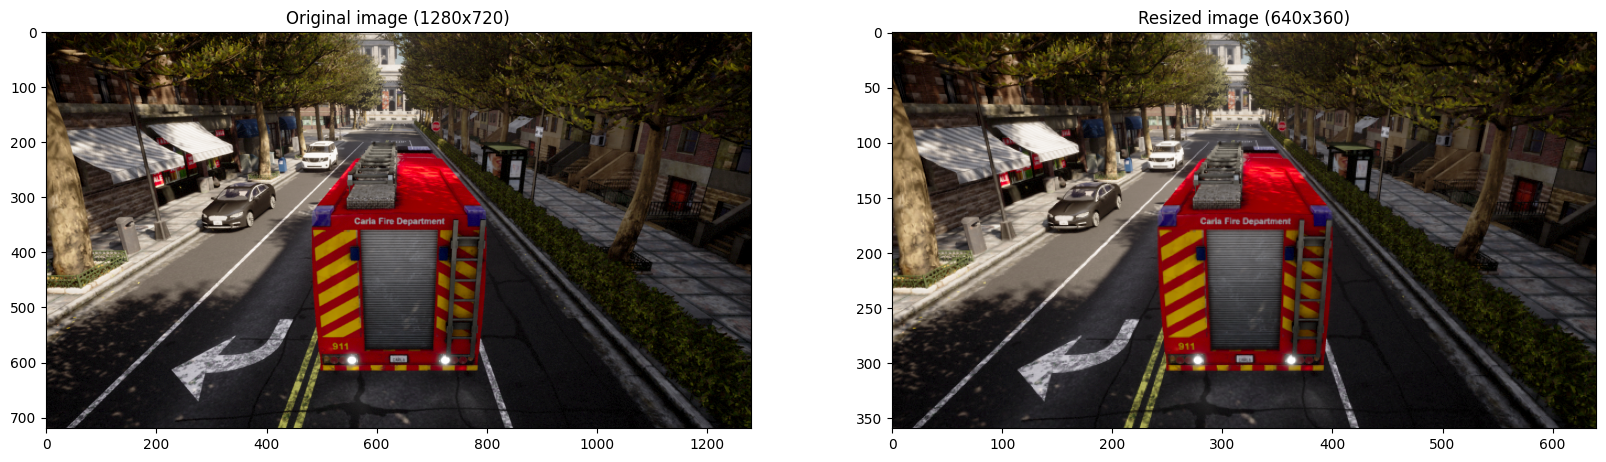

float32


In [4]:
resources_path = "resources"

image_path = os.path.join(resources_path, "example.png")
image = torchUtil.norm_numpy_image(cv2.imread(image_path).astype(np.float32) / 255.0)
image_size = (image.shape[1], image.shape[0])

# divide image image by 2
resized_image = cv2.resize(image, (image_size[0] // super_res_factor, image_size[1] // super_res_factor))
new_image_size = (resized_image.shape[1], resized_image.shape[0])

# apply transform to image
image_tensor = image_transforme(image).to(device)
resized_tensor = image_transforme(resized_image).to(device)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(torchUtil.tensor_to_image(image_tensor))
ax[0].set_title(f"Original image ({image_size[0]}x{image_size[1]})")

ax[1].imshow(torchUtil.tensor_to_image(resized_tensor))
ax[1].set_title(f"Resized image ({new_image_size[0]}x{new_image_size[1]})")

plt.show()

print(image.dtype)

In [5]:
patch_size = 32

num_patch_width = math.ceil(new_image_size[0] / patch_size)
num_patch_height = math.ceil(new_image_size[1] / patch_size)

num_patch_total = num_patch_width * num_patch_height

resized_patches = PatchImageTool.get_patchs_from_image(resized_tensor, patch_size=patch_size)

print(image_tensor.shape, image_tensor.dtype, resized_patches.dtype)

print(resized_patches.shape, num_patch_width, num_patch_height, num_patch_total)


torch.Size([3, 720, 1280]) torch.float32 torch.float32
torch.Size([240, 3, 32, 32]) 20 12 240


In [6]:
num_cols = min(5, num_patch_width)
num_rows = min(5, num_patch_height)

# Show some image patches
fig, ax = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
for i in range(num_rows):
    for j in range(num_cols):
        # ndarray
        
        ax[i, j].imshow(torchUtil.tensor_to_image(resized_patches[i * num_patch_width + j]))
        ax[i, j].set_title(f"Patch {i * num_patch_width + j}")
        ax[i, j].axis('off')

In [ ]:
from torchvision.transforms.v2 import Resize

def resize_tensor(tensor, size):
    return Resize(size, antialias=True)(tensor)

def resize_tensor_to_numpy(tensor, size):
    return torchUtil.tensor_to_numpy(resize_tensor(tensor, size))

Patch tensor size torch.Size([3, 32, 32]) type torch.float32
Prediction tensor size torch.Size([3, 64, 64]) type torch.float32


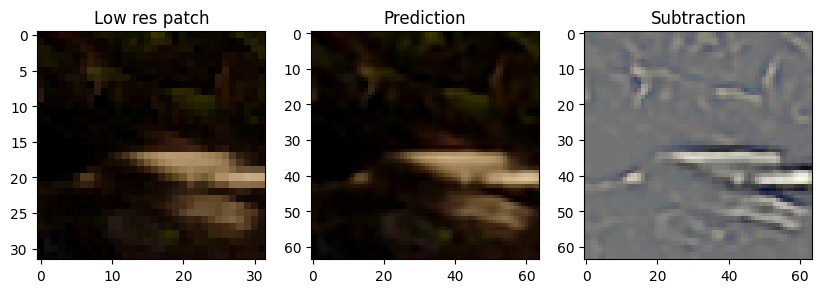

In [ ]:
# Make the model predict one patch
patch_index = 0

patch = resized_patches[patch_index].to(device)
print("Patch tensor size", patch.shape, "type", patch.dtype)

with torch.no_grad():
    prediction = exp.net(patch)
    prediction = prediction.squeeze(0)
    """prediction = exp.net(prediction)
    prediction = prediction.squeeze(0)"""

    print("Prediction tensor size", prediction.shape, "type", prediction.dtype)

    bilinear = resize_tensor_to_numpy(patch, (patch_size * super_res_factor, patch_size * super_res_factor))

    subtraction = torchUtil.norm_numpy_image(torchUtil.tensor_to_numpy(prediction) - bilinear)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(torchUtil.tensor_to_image(patch.squeeze(0).cpu()))
ax[0].set_title(f"Low res patch")

ax[1].imshow(torchUtil.tensor_to_image(prediction))
ax[1].set_title(f"Prediction")

ax[2].imshow(torchUtil.numpy_to_image(subtraction))
ax[2].set_title(f"Subtraction")

plt.show()

In [ ]:
# Make the prediction via full image

"""
with torch.no_grad():
    prediction = exp.net(resized_tensor)
    prediction = prediction.squeeze(0)

    #prediction = exp.net(prediction)
    #prediction = prediction.squeeze(0)

    print("Prediction tensor size", prediction.shape, "type", prediction.dtype)

    bilinear = resize_tensor_to_numpy(resized_tensor, (image_size[1], image_size[0]))

    subtraction = torchUtil.norm_numpy_image(torchUtil.tensor_to_numpy(prediction) - bilinear)

fig, ax = plt.subplots(1, 3, figsize=(20, 15))
ax[0].imshow(torchUtil.tensor_to_image(resized_tensor))
ax[0].set_title(f"Low res image")

ax[1].imshow(torchUtil.tensor_to_image(prediction))
ax[1].set_title(f"Prediction")

ax[2].imshow(torchUtil.numpy_to_image(subtraction))
ax[2].set_title(f"Subtraction")"""

'\nwith torch.no_grad():\n    prediction = exp.net(resized_tensor)\n    prediction = prediction.squeeze(0)\n\n    #prediction = exp.net(prediction)\n    #prediction = prediction.squeeze(0)\n\n    print("Prediction tensor size", prediction.shape, "type", prediction.dtype)\n\n    bilinear = resize_tensor_to_numpy(resized_tensor, (image_size[1], image_size[0]))\n\n    subtraction = torchUtil.norm_numpy_image(torchUtil.tensor_to_numpy(prediction) - bilinear)\n\nfig, ax = plt.subplots(1, 3, figsize=(20, 15))\nax[0].imshow(torchUtil.tensor_to_image(resized_tensor))\nax[0].set_title(f"Low res image")\n\nax[1].imshow(torchUtil.tensor_to_image(prediction))\nax[1].set_title(f"Prediction")\n\nax[2].imshow(torchUtil.numpy_to_image(subtraction))\nax[2].set_title(f"Subtraction")'

In [ ]:
# Use image
#image_upscaled_torch = prediction
# Use patches reconstructed image
image_upscaled_torch = PatchImageTool.predict_image_from_image_patches(
                    exp, image_size, resized_patches, 
                    device, 
                    patch_size=patch_size, upscale_factor=super_res_factor)

image_numpy = torchUtil.tensor_to_numpy(image_tensor)
image_to_show = torchUtil.numpy_to_image(image_numpy)

upscaled_numpy = torchUtil.tensor_to_numpy(image_upscaled_torch)
upscaled_image = torchUtil.numpy_to_image(upscaled_numpy)

bicubic_numpy = resize_tensor_to_numpy(resized_tensor, (image_size[1], image_size[0]))
bicubic_image = torchUtil.numpy_to_image(bicubic_numpy)

substract_numpy = torchUtil.norm_numpy_image(image_numpy - bicubic_numpy)
substract_image = torchUtil.numpy_to_image(substract_numpy)

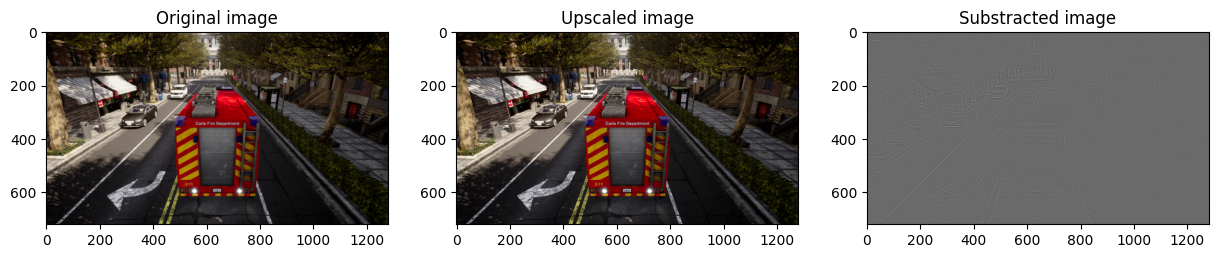

In [ ]:
# Show the original image, the predicted and the substracted image

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(image_to_show)
ax[0].set_title(f"Original image")

ax[1].imshow(upscaled_image)
ax[1].set_title(f"Upscaled image")

ax[2].imshow(substract_image, vmin=substract_numpy.min(), vmax=substract_numpy.max())
ax[2].set_title(f"Substracted image")

plt.show()

In [ ]:
# Compute PSNR and SSIM
psnr = metrics.peak_signal_noise_ratio(torchUtil.tensor_to_numpy(image_tensor), torchUtil.tensor_to_numpy(image_upscaled_torch))
ssim = metrics.structural_similarity(torchUtil.tensor_to_numpy(image_tensor), torchUtil.tensor_to_numpy(image_upscaled_torch), \
                                     win_size=7, data_range=1, multichannel=True, channel_axis=2)

print(f"Model PSNR: {psnr} SSIM: {ssim}")

bicubic_psnr = metrics.peak_signal_noise_ratio(torchUtil.tensor_to_numpy(image_tensor), bicubic_numpy)
bicubic_ssim = metrics.structural_similarity(torchUtil.tensor_to_numpy(image_tensor), bicubic_numpy, \
                                     win_size=7, data_range=1, multichannel=True, channel_axis=2)

print(f"Bicubic PSNR: {bicubic_psnr} SSIM: {bicubic_ssim}")

Model PSNR: 31.7346305699507 SSIM: 0.8897075653076172
Bilinear PSNR: 30.566740222935284 SSIM: 0.8602466583251953


In [ ]:
# Saving the image results

output_path = "results/examples/"

if not os.path.exists(output_path):
    os.makedirs(output_path)

# empty the output folder

for filename in os.listdir(output_path):
    file_path = os.path.join(output_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

if not os.path.exists(output_path):
    os.makedirs(output_path)

# Save the original image
cv2.imwrite(os.path.join(output_path, "original.png"), image_numpy * 255.0)
# Save the upscaled image
cv2.imwrite(os.path.join(output_path, "upscaled.png"), upscaled_numpy * 255.0)
# Save the bilinear image
cv2.imwrite(os.path.join(output_path, "bicubic.png"), bicubic_numpy * 255.0)
# Save the substracted image
cv2.imwrite(os.path.join(output_path, "substracted.png"), torchUtil.numpy_to_image(substract_numpy) * 255.0)


True